## This script plots the distribution of the closest distance between the cluster center to the UGUGUG motif, on FLARE confident clusters

## MeOH samples compared with PFA samples

In [1]:
import os
cwd = os.getcwd()
main_dir = cwd
print(main_dir)

/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks


In [2]:
import pandas as pd
from glob import glob
import pybedtools
import subprocess

figure_dir = main_dir + "/figures_density_plot/"
subprocess.run(["mkdir", figure_dir])

CompletedProcess(args=['mkdir', '/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/figures_density_plot/'], returncode=1)

In [3]:
peak_filepaths = sorted(glob(main_dir + '/confident_clusters/*bed'))
print(len(peak_filepaths))

10


In [4]:
from pyfaidx import Fasta
import re
fasta = '/tscc/projects/ps-yeolab3/ekofman/ReferenceData/hg38/cellranger-GRCh38-3.0.0/fasta/genome.fa'
FA = Fasta(fasta, rebuild=False)
import math

def get_sequence(r): 
    chrom = r.chrom.split('chr')[-1]
    if chrom == 'M':
        return
    start = r.start
    end = r.end
    strand = r.strand
    
    sequence = FA[chrom][start:end].seq
    sequence = sequence.upper()
        
    return sequence

def get_extended_sequence(r): 
    chrom = r.chrom.split('chr')[-1]
    if chrom == 'M':
        return
    
    midpoint = r.start + (int((r.end - r.start)/2))
    start = midpoint - 400
    end = midpoint + 400
    strand = r.strand
    
    sequence = FA[chrom][start:end].seq
    sequence = sequence.upper()
        
    return sequence

complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
def reverse_complement(seq):
    return "".join(complement.get(base, base) for base in reversed(seq))

def reverse(seq):
    return seq[::-1]

def motif_present(sequence, motif, strand):
    if sequence == None:
        return
    if strand == '+':
        return motif in sequence
    elif strand == '-':
        return reverse_complement(motif) in sequence

def motif_distance_from_center(sequence, motif, strand):
    # print(sequence)
    if strand == '+':
        search_term = motif
    elif strand == '-':
        search_term = reverse_complement(motif)
    else:
        search_term = motif
    if sequence == None:
        return
    if search_term in sequence:
        closest_position_in_first_half = 1000
        closest_position_in_second_half = 1000
        
        midpoint = math.ceil(len(sequence)/2)
        #print('\tmidpoint is {}'.format(midpoint))
        start_of_second_half = midpoint-len(motif)

        sequence_first_half = sequence[0:midpoint]
        sequence_second_half = sequence[start_of_second_half:]

        #print('\tSplit:', sequence_first_half, sequence_second_half)
        if search_term in sequence_first_half:
            flipped_sequence = reverse(sequence_first_half)
            flipped_search_term = reverse(search_term)
            
            #print('searching for {} in {}'.format(flipped_search_term, flipped_sequence))
            closest_position_in_first_half = - flipped_sequence.index(flipped_search_term) - math.floor(len(motif)/2)
            
        if search_term in sequence_second_half:
            closest_position_in_second_half = sequence_second_half.index(search_term) - math.floor(len(motif)/2)

        #print([closest_position_in_first_half, closest_position_in_second_half])
        if min(abs(closest_position_in_second_half), abs(closest_position_in_first_half)) == abs(closest_position_in_second_half):
            return closest_position_in_second_half
        else:
            return closest_position_in_first_half
    else:
        return None
    
motifs = ['TGTGTG', 'GTGTGT']

def add_sequence_presences(r, window_size=70):
    extended_sequence = r['extended_sequence(+)']
    strand = r.strand

    distance_tgcatg = motif_distance_from_center(extended_sequence, 'TGTGTG', strand)
    distance_agcatg = motif_distance_from_center(extended_sequence, 'GTGTGT', strand)


    sequence = r['sequence(+)']

    presence_map = {motif: motif_present(sequence, motif, strand) for motif in motifs}
    return presence_map.get(motifs[0]), presence_map.get(motifs[1]), distance_tgcatg, distance_agcatg

def calculate_fractions(p_df):
    fractions_dict = {}
    counts_dict = {}
    
    for motif in motifs + ['any_motif']:
        motif_present_count = p_df[motif].sum()
        motif_present_fraction = motif_present_count/len(p_df)
        fractions_dict[motif] = motif_present_fraction
        counts_dict[motif] = motif_present_count
    
    return fractions_dict, counts_dict

In [5]:
stamp_file_dfs = {}
all_file_ids = []
peak_counts_lst = []

for peak_filepath in peak_filepaths:    
    print(peak_filepath)
    file_id = peak_filepath.split('/')[-1].split('_cleaned')[0]    
    if 'bed' in file_id:
        continue
    print('\t', file_id)
    all_file_ids.append(file_id)
    df = pd.read_csv(peak_filepath, sep='\t', index_col=False, names =['chrom','start', 'end','score', 'edits', 'strand'])
    # df = df[df['chrom'].isin(common_chroms)]
    print(len(df))
    peak_counts_lst.append(len(df))
    stamp_file_dfs[file_id] = df

/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/confident_clusters/ANonly_cleaned_confident_peaks.bed
	 ANonly
2168
/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/confident_clusters/Buffer_Only_PFA_confident_clusters.bed
/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/confident_clusters/Enzyme Only PFA_cleaned_confident_clusters.bed
	 Enzyme Only PFA
1678
/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/confident_clusters/Enzyme_Only_PFA_confident_clusters.bed
/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/confident_clusters/RBFOX2 INSCRIBE PFA_cleaned_confident_clusters.bed
	 RBFOX2 INSCRIBE PFA
2970
/tscc/lustre/ddn/scratch/q2liang/isSTAMP_publication_scripts/example_analysis_notebooks/confident_clusters/RBFOX2_INSCRIBE_PFA_confident_clusters.bed
/tscc/lustre/ddn/scratch/q2liang/isSTAMP

In [6]:
df_peak_count_info = pd.DataFrame([all_file_ids,peak_counts_lst])
df_peak_count_info = df_peak_count_info.transpose()
df_peak_count_info.columns = ['sample', 'peak counts']
df_peak_count_info = df_peak_count_info.sort_values(by = 'sample')
df_peak_count_info

,sample,peak counts
0,ANonly,2168
1,Enzyme Only PFA,1678
3,RBFOX2,5602
2,RBFOX2 INSCRIBE PFA,2970
5,TDP43,5751
4,TDP43 INSCRIBE PFA,2540


In [7]:
from collections import defaultdict

actual_motif_fractions = defaultdict(lambda:{})
dfs_with_motif_info = {}
for label,df in stamp_file_dfs.items():
    print(label)
    if 'RBFOX2' in label:
        continue
    print('\t', len(df))
    df['sequence(+)'] = df.apply(get_sequence, axis=1)
    df['extended_sequence(+)'] = df.apply(get_extended_sequence, axis=1)
    # print(df['sequence(+)'])

    df[motifs[0]],df[motifs[1]],df['TGTGTG_dist_from_center'], df['GTGTGT_dist_from_center'] = zip(*df.apply(add_sequence_presences, axis=1))

    df['any_motif'] = df[[motifs[0], motifs[1]]].any(axis=1)
    dfs_with_motif_info[label] = df
    
    for motif in motifs:
        actual_motif_fractions[label][motif] = len(df[df[motif] == True])/len(df)

ANonly
	 2168
Enzyme Only PFA
	 1678
RBFOX2 INSCRIBE PFA
RBFOX2
TDP43 INSCRIBE PFA
	 2540
TDP43
	 5751


In [8]:
to_be_plotted = [ 'TDP43',  'ANonly', 'TDP43 INSCRIBE PFA','Enzyme Only PFA',]
print(to_be_plotted)

['TDP43', 'ANonly', 'TDP43 INSCRIBE PFA', 'Enzyme Only PFA']


### Plotting

/tscc/nfs/home/q2liang/miniconda3/envs/py3/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/tscc/nfs/home/q2liang/miniconda3/envs/py3/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/tscc/nfs/home/q2liang/miniconda3/envs/py3/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

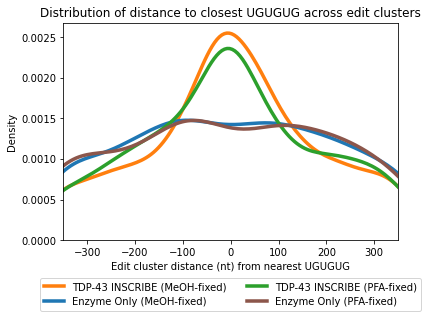

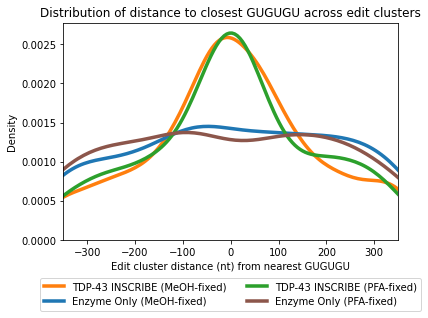

In [10]:
# Plot a subset of experiments
file_header = 'PFA-fix-compare-to-MeOH'

from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
plt.rcParams['pdf.fonttype'] = 42

to_plot_together = {}

to_plot_together_label = to_be_plotted


for experiment in to_plot_together_label:
    # print(experiment)
    df = dfs_with_motif_info.get(experiment)
    df_with_dists = df[~df.TGTGTG_dist_from_center.isna()]
    
    to_plot_together[experiment] = df_with_dists
        

distance_columns = [c for c in list(df.columns[-9:]) if 'dist' in c]

legend = legend = ['TDP-43 INSCRIBE (MeOH-fixed)', 'Enzyme Only (MeOH-fixed)', 'TDP-43 INSCRIBE (PFA-fixed)', 'Enzyme Only (PFA-fixed)']

colors = ["#ff7f0e", "#1f77b4" , "#2ca02c", "#8c564b"]
sns.set_palette(sns.color_palette(colors))

for c in distance_columns:

    plt.figure(figsize=(6, 4))
    for label, df in to_plot_together.items():
        # legend.append(label)
        plt.xlim(-350, 350)
        # plt.ylim(0.00075, 0.00225)
        g = sns.distplot(df[c], hist=False, kde_kws=dict(linewidth=3.5))
        # g.set(yticklabels=[])
        plt.legend(legend, bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=2)
        motif_label = c.split('_')[0]
        plt.xlabel("Edit cluster distance (nt) from nearest {}".format(motif_label).replace('T', 'U'))
        plt.ylabel("Density")
        plt.title("Distribution of distance to closest {} across edit clusters".format(motif_label).replace('T', 'U'), fontsize = 12)
#         plt.savefig(figure_dir + '/{}_distance_to_center_{}_2024.png'.format(motif_label, file_header), bbox_inches='tight', dpi = 300)
#         plt.savefig(figure_dir + '/{}_distance_to_center_{}_2024.svg'.format(motif_label, file_header),bbox_inches='tight', dpi = 300)
#         plt.savefig(figure_dir + '/{}_distance_to_center_{}_2024.pdf'.format(motif_label, file_header),bbox_inches='tight', dpi = 300)

